In [2]:
msg = "Hello World"
print(msg)

Hello World


In [3]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql import HiveContext

sc = SparkContext()
sqlContext = SQLContext(sc)

# sqlContext = HiveContext(sc)
# spark = SparkSession.builder.master("yarn").appName("my app").enableHiveSupport().getOrCreate()
spark = SparkSession(sc)
# spark = SparkSession \
#     .builder \
#     .appName("Python Spark SQL Hive integration example") \
#     .config("spark.sql.warehouse.dir", warehouse_location) \
#     .enableHiveSupport() \
#     .getOrCreate()

# load up other dependencies
import re
import pandas as pd

import glob

raw_data_files = glob.glob('../ansible/.results-1/bpftrace/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-------------------------------------------------------------+
|value                                                        |
+-------------------------------------------------------------+
|Attaching 12 probes...                                       |
|Tracing latency of network stack funtions. Hit Ctrl-C to end.|
|@q1[openssl]: count 144, average 1426, total 205480          |
|@q1[ksoftirqd/169]: count 3, average 4558, total 13676       |
|                                                             |
|@q2[openssl]: count 885, average 7709, total 6823275         |
|@q2[ksoftirqd/169]: count 25, average 792608, total 19815215 |
|                                                             |
|                                                             |
|@q4[openssl]: count 9818, average 963, total 9462529         |
+-------------------------------------------------------------+
only showing top 10 rows



In [4]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['Attaching 12 probes...',
 'Tracing latency of network stack funtions. Hit Ctrl-C to end.',
 '@q1[openssl]: count 144, average 1426, total 205480',
 '@q1[ksoftirqd/169]: count 3, average 4558, total 13676',
 '',
 '@q2[openssl]: count 885, average 7709, total 6823275',
 '@q2[ksoftirqd/169]: count 25, average 792608, total 19815215',
 '',
 '',
 '@q4[openssl]: count 9818, average 963, total 9462529',
 '@q4[ksoftirqd/169]: count 134, average 976, total 130860',
 '',
 '@q5[openssl]: count 74686, average 431, total 32241418',
 '@q5[ksoftirqd/169]: count 992, average 436, total 432893',
 '']

In [5]:
bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
ps = [re.search(bpftrace_ps_pattern, item).groups()
           if re.search(bpftrace_ps_pattern, item)
           else None
           for item in sample_logs]
ps

[None,
 None,
 ('q1', 'openssl', '144', '1426', '205480', ''),
 ('q1', 'ksoftirqd/169', '3', '4558', '13676', ''),
 None,
 ('q2', 'openssl', '885', '7709', '6823275', ''),
 ('q2', 'ksoftirqd/169', '25', '792608', '19815215', ''),
 None,
 None,
 ('q4', 'openssl', '9818', '963', '9462529', ''),
 ('q4', 'ksoftirqd/169', '134', '976', '130860', ''),
 None,
 ('q5', 'openssl', '74686', '431', '32241418', ''),
 ('q5', 'ksoftirqd/169', '992', '436', '432893', ''),
 None]

In [6]:
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
cs = [re.search(bpftrace_cs_pattern, item).groups()
           if re.search(bpftrace_cs_pattern, item)
           else None
           for item in sample_logs]
cs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+--------+
|cs_count|cs_average|cs_total|
+--------+----------+--------+
|    1956|     36808|71997546|
|    2319|      7019|16279026|
|    2051|      6609|13556402|
|    2140|      6742|14428561|
|    1923|      6484|12469887|
|    2164|      6140|13288477|
|    1992|      6573|13093701|
|    1937|      6092|11801469|
|    2063|      7117|14683151|
|    2213|      8127|17986832|
|    2417|     14052|33965376|
|    2188|     14069|30783495|
|    1914|      5913|11317637|
|    2331|      6963|16231186|
|    2057|      6870|14131988|
+--------+----------+--------+
only showing top 15 rows



In [8]:
print(bpftrace_cs_df.toPandas().to_numpy()[0])

['1956' '36808' '71997546']


In [9]:
from pyspark.sql.functions import regexp_extract

bpftrace_logs_df = base_df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
bpftrace_logs_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|
+-----+-------------+---------+-----------+---------+
|   q1|      openssl|      144|       1426|   205480|
|   q1|ksoftirqd/169|        3|       4558|    13676|
|   q2|      openssl|      885|       7709|  6823275|
|   q2|ksoftirqd/169|       25|     792608| 19815215|
|   q4|      openssl|     9818|        963|  9462529|
|   q4|ksoftirqd/169|      134|        976|   130860|
|   q5|      openssl|    74686|        431| 32241418|
|   q5|ksoftirqd/169|      992|        436|   432893|
|   q1|      openssl|      294|       1184|   348176|
|   q1|ksoftirqd/169|        7|       2250|    15750|
|   q2|      openssl|     1576|        627|   989301|
|   q2|ksoftirqd/169|       37|        786|    29086|
|   q4|      openssl|    13333|        954| 12730617|
|   q4|ksoftirqd/169|       90|        986|    88773|
|   q5|      openssl|   101432|        430| 43715288|
+-----+-------------+-------

In [10]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+--------+
|cs_count|cs_average|cs_total|
+--------+----------+--------+
|    1956|     36808|71997546|
|    2319|      7019|16279026|
|    2051|      6609|13556402|
|    2140|      6742|14428561|
|    1923|      6484|12469887|
|    2164|      6140|13288477|
|    1992|      6573|13093701|
|    1937|      6092|11801469|
|    2063|      7117|14683151|
|    2213|      8127|17986832|
|    2417|     14052|33965376|
|    2188|     14069|30783495|
|    1914|      5913|11317637|
|    2331|      6963|16231186|
|    2057|      6870|14131988|
+--------+----------+--------+
only showing top 15 rows



In [11]:
cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]
print(cs_array)

['1956' '36808' '71997546']


In [12]:
from pyspark.sql.functions import lit

bpftrace_res_df = bpftrace_logs_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
bpftrace_res_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|
+-----+-------------+---------+-----------+---------+--------+----------+--------+
|   q1|      openssl|      144|       1426|   205480|    1956|     36808|71997546|
|   q1|ksoftirqd/169|        3|       4558|    13676|    1956|     36808|71997546|
|   q2|      openssl|      885|       7709|  6823275|    1956|     36808|71997546|
|   q2|ksoftirqd/169|       25|     792608| 19815215|    1956|     36808|71997546|
|   q4|      openssl|     9818|        963|  9462529|    1956|     36808|71997546|
|   q4|ksoftirqd/169|      134|        976|   130860|    1956|     36808|71997546|
|   q5|      openssl|    74686|        431| 32241418|    1956|     36808|71997546|
|   q5|ksoftirqd/169|      992|        436|   432893|    1956|     36808|71997546|
|   q1|      openssl|      294|       1184|   348176|    1956|     36808|71997546|
|   

In [13]:
raw_data_files = glob.glob('../ansible/.results-1/iperf/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+---------------------------------------------------------------------------------+
|value                                                                            |
+---------------------------------------------------------------------------------+
|------------------------------------------------------------                     |
|Server listening on UDP port 5001                                                |
|Receiving 1470 byte datagrams                                                    |
|UDP buffer size:  208 KByte (default)                                            |
|------------------------------------------------------------                     |
|[  3] local 10.0.0.2 port 5001 connected with 10.0.0.1 port 42731                |
|[ ID] Interval       Transfer     Bandwidth        Jitter   Lost/Total Datagrams |
|[  3]  0.0-59.9 sec  8.37 GBytes  1.20 Gbits/sec   0.012 ms 10349/6122450 (0.17%)|
+--------------------------------

In [14]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(iperf_s_pattern, item).groups()
           if re.search(iperf_s_pattern, item)
           else None
           for item in sample_logs]
cs

[('', '', '', '', '', '', ''),
 None,
 None,
 None,
 ('', '', '', '', '', '', ''),
 None,
 None,
 ('59.9', '8.37', '1.20', '0.012', '10349/6122450', '0.17', '%)')]

In [15]:
raw_data_files = glob.glob('../ansible/.results-1/openssl/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-----------------------------------------------------------------------------+
|value                                                                        |
+-----------------------------------------------------------------------------+
|Doing aes-256 cbc for 10s on 16 size blocks: 87587487 aes-256 cbc's in 8.80s |
|Doing aes-256 cbc for 10s on 64 size blocks: 21898077 aes-256 cbc's in 8.49s |
|Doing aes-256 cbc for 10s on 256 size blocks: 5498092 aes-256 cbc's in 8.57s |
|Doing aes-256 cbc for 10s on 1024 size blocks: 1379086 aes-256 cbc's in 8.61s|
|Doing aes-256 cbc for 10s on 8192 size blocks: 172844 aes-256 cbc's in 8.50s |
|Doing aes-256 cbc for 10s on 16384 size blocks: 86377 aes-256 cbc's in 8.45s |
+-----------------------------------------------------------------------------+



In [16]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(openssl_s_pattern, item).groups()
           if re.search(openssl_s_pattern, item)
           else None
           for item in sample_logs]
cs

openssl_logs_df = base_df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')

openssl_logs_df.show(5)
cs_array = openssl_logs_df.toPandas().to_numpy()

us_time = 0.0
for a in cs_array:
    us_time += float(a[0])

us_time

+-------+
|us_time|
+-------+
|   8.80|
|   8.49|
|   8.57|
|   8.61|
|   8.50|
+-------+
only showing top 5 rows



51.42

In [17]:
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from functools import reduce

# schema = StructType([])
# results_df = sqlContext.createDataFrame(sc.emptyRDD(), schema)

bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'


def readFiletoDF(path) -> DataFrame:
    raw_data_files = glob.glob(path)
    raw_data_files
    return spark.read.text(raw_data_files)

def readBpftracePSLogstoDF(df: DataFrame) -> DataFrame:
    bpftrace_logs_df = df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
    return bpftrace_logs_df

def concateBpftraceCSLogstoDF(df: DataFrame, ps_df: DataFrame) -> DataFrame:
    bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
                                ).filter(' cs_count != ""')

    cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]

    bpftrace_res_df = ps_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
    
    return bpftrace_res_df

def concateIperfLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    iperf_logs_df = df.select(
                                regexp_extract('value', iperf_s_pattern, 1).alias('intval'),
                                regexp_extract('value', iperf_s_pattern, 2).alias('transfer'),
                                regexp_extract('value', iperf_s_pattern, 3).alias('rx_bandwidth'),
                                regexp_extract('value', iperf_s_pattern, 4).alias('jitter'),
                                regexp_extract('value', iperf_s_pattern, 6).alias('pkt_loss')
                                ).filter(' intval != "" ')
    
    cs_array = iperf_logs_df.toPandas().to_numpy()[0]

    iperf_res_df = in_df.withColumn("duration", lit(cs_array[0])
                    ).withColumn("rx_gbytes", lit(cs_array[1])
                    ).withColumn("rx_bandwidth", lit(cs_array[2])
                    ).withColumn("jitter", lit(cs_array[3])
                    ).withColumn("pkt_loss", lit(cs_array[4]))

    iperf_res_df.show(5)
    return iperf_res_df

def concateOpensslLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    openssl_logs_df = df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')
    
    cs_array = openssl_logs_df.toPandas().to_numpy()

    us_time = 0.0
    for a in cs_array:
        us_time += float(a[0])

    us_time

    openssl_res_df = in_df.withColumn("us_time", lit(us_time))

    return openssl_res_df

df_list = []

for x in range(1, 50):
    path = '../ansible/.results-1/bpftrace/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    ps_df = readBpftracePSLogstoDF(base_df)
    ps_cs_df = concateBpftraceCSLogstoDF(base_df, ps_df)
    df_1 = ps_cs_df.withColumn("tx_bandwidth", lit(1000 + 200*x))

    path = '../ansible/.results-1/iperf/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_2 = concateIperfLogsToDF(base_df, df_1)

    path = '../ansible/.results-1/openssl/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_3 = concateOpensslLogsToDF(base_df, df_2)

    df_list.append(df_3)

results_df = reduce(lambda x, y: x.union(y), df_list)
# results_df.show(5, truncate=False)
results_df.printSchema()


+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|
+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+
|   q1|      openssl|      144|       1426|   205480|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|    0.17|
|   q1|ksoftirqd/169|        3|       4558|    13676|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|    0.17|
|   q2|      openssl|      885|       7709|  6823275|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|    0.17|
|   q2|ksoftirqd/169|       25|     792608| 19815215|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|  

In [18]:
from pyspark.sql import SparkSession

results_df.show(100)
results_df.createOrReplaceTempView("LOGS")


df2=spark.sql("select level, tx_bandwidth, sum(pkt_count) as count, avg(rx_gbytes) as rx_bytes from LOGS group by level, tx_bandwidth")
df2.show(5, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+-------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|us_time|
+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+-------+
|   q1|      openssl|      144|       1426|   205480|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|    0.17|  51.42|
|   q1|ksoftirqd/169|        3|       4558|    13676|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|    0.17|  51.42|
|   q2|      openssl|      885|       7709|  6823275|    1956|     36808|71997546|        1200|    59.9|     8.37|        1.20| 0.012|    0.17|  51.42|
|   q2|ksoftirqd/169|       25|     792608| 19815215|    1956|     36808|71997546|      


This graph shows the time taken executing packets on each level of packet processing for a given bandwith



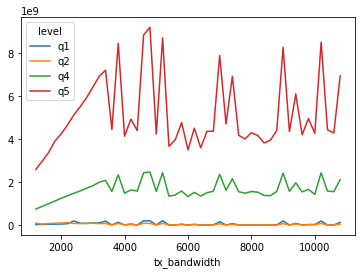

In [19]:
caption = '''
This graph shows the time taken executing packets on each level of packet processing for a given bandwith
'''

df2=spark.sql("select level, tx_bandwidth, sum(pkt_total) as time from LOGS group by level, tx_bandwidth order by tx_bandwidth")

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='time')

df_2.plot()
print(caption)

+------------+------------------+
|tx_bandwidth|              time|
+------------+------------------+
|        1200| 51.41999999999931|
|        1400|49.770000000000366|
|        1600|46.849999999999646|
|        1800|  35.0600000000002|
|        2000| 43.99000000000041|
|        2200|  43.5600000000004|
|        2400|49.540000000000596|
|        2600|37.590000000000124|
|        2800| 25.37000000000027|
|        3000| 23.62000000000023|
|        3200|29.229999999999674|
|        3400| 28.21999999999978|
|        3600|30.980000000000015|
|        3800|23.700000000000195|
|        4000|             30.75|
|        4200| 29.10999999999989|
|        4400|30.820000000000068|
|        4600|27.229999999999688|
|        4800|25.959999999999635|
|        5000| 31.11999999999992|
|        5200|21.219999999999885|
|        5400|30.190000000000037|
|        5600|31.070000000000068|
|        5800| 29.60000000000007|
|        6000|31.349999999999937|
|        6200|29.619999999999916|
|        6400|

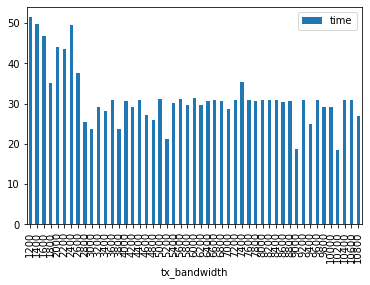

In [20]:
caption = '''
This graph shows the amount of time spent by the CPU operating on the userspace program for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(us_time) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df3.show(100)
df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)



This graph shows the amount of time spent handling context switches for each TX bandwidth



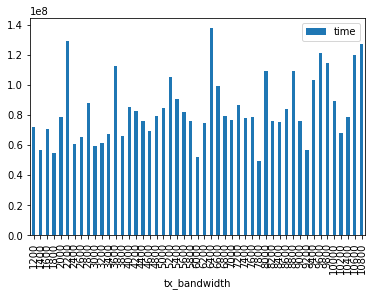

In [21]:
caption = '''
This graph shows the amount of time spent handling context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_total) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)

+------------+-------+
|tx_bandwidth|  count|
+------------+-------+
|        1200| 1956.0|
|        1400| 2116.0|
|        1600| 1891.0|
|        1800| 2458.0|
|        2000| 2675.0|
|        2200| 3212.0|
|        2400| 1996.0|
|        2600| 2324.0|
|        2800| 2624.0|
|        3000| 2210.0|
|        3200| 3127.0|
|        3400| 3324.0|
|        3600| 4289.0|
|        3800| 4317.0|
|        4000| 4933.0|
|        4200| 5183.0|
|        4400| 4626.0|
|        4600| 3856.0|
|        4800| 3811.0|
|        5000| 3829.0|
|        5200| 4302.0|
|        5400| 4146.0|
|        5600| 5931.0|
|        5800| 5004.0|
|        6000|  644.0|
|        6200| 5020.0|
|        6400| 5687.0|
|        6600| 3774.0|
|        6800| 5119.0|
|        7000| 3565.0|
|        7200| 2600.0|
|        7400|10924.0|
|        7600| 5633.0|
|        7800| 3604.0|
|        8000| 5919.0|
|        8200| 4411.0|
|        8400| 4032.0|
|        8600| 5859.0|
|        8800| 4980.0|
|        9000| 5087.0|
|        92

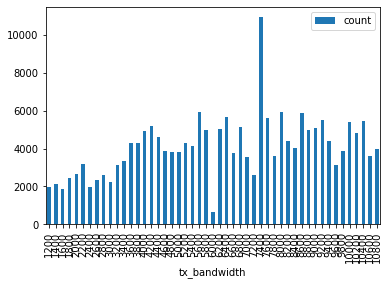

In [22]:
caption = '''
This graph shows the number of context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_count) as count from LOGS group by tx_bandwidth order by tx_bandwidth")

df3.show(100)
df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='count')
print(caption)

+-----+------------+------------------+
|level|tx_bandwidth|         rx_gbytes|
+-----+------------+------------------+
|   q4|        1200| 8.369999999999989|
|   q2|        1200| 8.369999999999989|
|   q5|        1200| 8.369999999999989|
|   q1|        1200| 8.370000000000003|
|   q5|        1400| 9.759999999999993|
|   q2|        1400| 9.759999999999993|
|   q4|        1400| 9.759999999999993|
|   q1|        1400| 9.759999999999993|
|   q5|        1600|11.200000000000028|
|   q4|        1600|11.200000000000028|
|   q1|        1600|11.200000000000026|
|   q2|        1600|11.200000000000028|
|   q4|        1800|12.599999999999962|
|   q1|        1800| 12.59999999999997|
|   q2|        1800|12.599999999999964|
+-----+------------+------------------+
only showing top 15 rows



<AxesSubplot:xlabel='tx_bandwidth'>

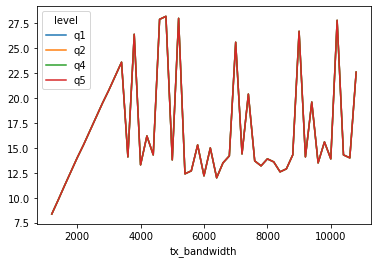

In [23]:
caption = '''
This graph shows the amount of giga bytes on each level of packet processing for a given bandwith
'''

results_df.createOrReplaceTempView("LOGS")
df2=spark.sql("select level, tx_bandwidth, avg(rx_gbytes) as rx_gbytes from LOGS group by level, tx_bandwidth order by tx_bandwidth ")
df2.show(15, truncate=True)

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='rx_gbytes')

df_2.plot()

+------------+------------------+
|tx_bandwidth|         rx_gbytes|
+------------+------------------+
|        1200| 8.369999999999918|
|        1400| 9.760000000000133|
|        1600|11.199999999999891|
|        1800|12.600000000000142|
|        2000|              14.0|
|        2200|15.300000000000022|
|        2400|16.699999999999957|
|        2600|  18.1000000000002|
|        2800|              19.5|
|        3000|20.799999999999894|
|        3200|22.200000000000195|
|        3400|23.600000000000215|
|        3600| 14.09999999999997|
|        3800|26.399999999999757|
|        4000| 13.29999999999997|
+------------+------------------+
only showing top 15 rows


This graph shows the number receive bytes for each TX bandwidth



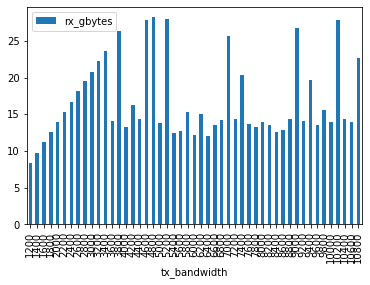

In [24]:
caption = '''
This graph shows the number receive bytes for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(rx_gbytes) rx_gbytes from LOGS group by tx_bandwidth order by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='rx_gbytes')
print(caption)

+------------+-------------------+
|tx_bandwidth|           pkt_loss|
+------------+-------------------+
|        1200| 0.1700000000000014|
|        1400| 0.1700000000000014|
|        1600|0.05300000000000058|
|        1800| 0.1500000000000011|
|        2000|0.09799999999999937|
|        2200|0.17000000000000143|
|        2400| 0.4199999999999953|
|        2600| 0.4399999999999981|
|        2800| 0.4799999999999961|
|        3000| 0.5200000000000025|
|        3200| 0.5600000000000019|
|        3400|  0.550000000000005|
|        3600|               44.0|
|        3800|                0.5|
|        4000|               53.0|
+------------+-------------------+
only showing top 15 rows


This graph shows the packet loss for each TX bandwidth



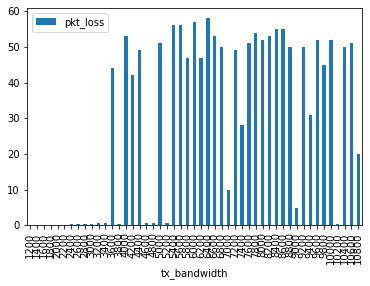

In [25]:
caption = '''
This graph shows the packet loss for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(pkt_loss) pkt_loss from LOGS group by tx_bandwidth order by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='pkt_loss')
print(caption)

+------------+-------------+-------------+
|tx_bandwidth|      program|         time|
+------------+-------------+-------------+
|        1200|kworker/169:1|    3033681.0|
|        1200|ksoftirqd/169|  4.2484381E7|
|        1200|      openssl|3.383961713E9|
|        1200|  swapper/169|    4269373.0|
|        1400|ksoftirqd/169|    2.75476E7|
|        1400|      openssl|3.838353953E9|
|        1400|kworker/169:2|    1470264.0|
|        1400|  swapper/169|  2.8187705E7|
|        1400|kworker/169:0|     743734.0|
|        1600|kworker/169:2|    2617016.0|
|        1600|      openssl|4.401031317E9|
|        1600|  swapper/169|    7455274.0|
|        1600|        iperf|      56427.0|
|        1600|ksoftirqd/169|  3.7117782E7|
|        1800|  swapper/169|  2.1080669E7|
+------------+-------------+-------------+
only showing top 15 rows


This graph shows the program the packets are processed in contexts of for each TX bandwidth



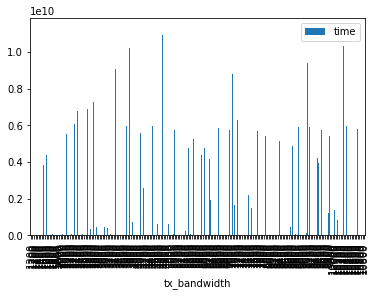

In [26]:
caption = '''
This graph shows the program the packets are processed in contexts of for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, program, sum(pkt_total) as time from LOGS group by tx_bandwidth, program order by tx_bandwidth")
df3.show(15, truncate=True)



df4=spark.sql("select DISTINCT program from LOGS")
df4.show(15, truncate=True)
 
df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y=['time', 'program'])
print(caption)